In [2]:
import pandas as pd
import numpy as np
import requests
import os
import threading

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [2]:
!rm -rf /content/image_data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/image_data.zip" -d /content/
!cp "/content/drive/MyDrive/Colab Notebooks/fitzpatrick17k.csv" /content/fitzpatrick17k.csv
#!cp /content/drive/MyDrive/Colab\ Notebooks/*.keras /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/image_data/actinic keratosis/actinic_keratoses102.jpg  
  inflating: /content/image_data/actinic keratosis/transient-acantholytic-dermatosis-grovers-disease1.jpg  
  inflating: /content/image_data/actinic keratosis/arsenic_keratoses4.jpg  
  inflating: /content/image_data/actinic keratosis/img?imageId=3070.jpg  
  inflating: /content/image_data/actinic keratosis/img?imageId=3064.jpg  
  inflating: /content/image_data/actinic keratosis/actinic_keratoses39.jpg  
  inflating: /content/image_data/actinic keratosis/actinic_keratoses10.jpg  
  inflating: /content/image_data/actinic keratosis/actinic_keratoses38.jpg  
  inflating: /content/image_data/actinic keratosis/img?imageId=3065.jpg  
  inflating: /content/image_data/actinic keratosis/img?imageId=3071.jpg  
  inflating: /content/image_data/actinic keratosis/arsenic_keratoses5.jpg  
  inflating: /content/image_data/actinic keratosis/arsenic_keratoses7.jpg  
  inflat

In [5]:
def convert_url(url):
    """
    Convert URL alphanumeric in a current URLs.

    Inputs:
        url(str): URL alphanumeric.

    Outputs:
        URL string.
    """
    url = url.replace("httpwwwdermaamincom", "https://www.dermaamin.com")
    url = url.replace("siteimages", "site/images/")
    url = url.replace("clinicalpicLLichensimplexchronicusLichensimplexchronicus", "clinical-pic/L/lichen_simplex/lichen_simplex")
    url = url.replace("clinicalpicooralmucosalmelanomaoralmucosalmelanoma", "clinical-pic/o/oral-%20mucosal-melanoma/oral-%20mucosal-melanoma")
    url = url.replace("histopicjjunctionnaevusjunctionnaevus", "histo-pic/j/junction-naevus/junction-naevus")
    url = url.replace("site/images/l/", "site/images/")
    url = url.replace("jpg.jpg", ".jpg")
    url = url.replace("jpg", "jpg")
    url = url.replace("com", "com/")
    return url

In [6]:
def download_images_from_chunk(chunk):
    for label, url in chunk[['label', 'url']].values:
        try:
            output_path = "./image_data/" + label + "/" + url.split('/')[-1]
            if not output_path.endswith('.jpg'):
                output_path += '.jpg'

            # Skip if the image is already downloaded
            if os.path.exists(output_path):
                continue

            response = requests.get(url, stream=True, headers={'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"})
            if response.status_code == 200:
                with open(output_path, 'wb') as f:
                    f.write(response.content)
            else:
                print(f"Failed to download image from {url}")
        except Exception as e:
            print(f"Error while downloading image from {url}")

def download_images(df, n_threads=20, replace=False):
    image_chunks = np.array_split(df, n_threads)

    # Create folder structure
    root_path = "./image_data/"
    if not os.path.exists(root_path):
        os.makedirs(root_path)

    for label in df['label'].unique():
        label_path = root_path + label + "/"

        # Remove all files in the folder, if replace is True
        if replace and os.path.exists(label_path):
            for file in os.listdir(label_path):
                os.remove(label_path + file)

        if not os.path.exists(label_path):
            os.makedirs(label_path)

    threads = []
    # Download the images
    for chunk in image_chunks:
        t = threading.Thread(target=download_images_from_chunk, args=(chunk,))
        threads.append(t)
        t.start()

    # Wait all threads to finish
    for t in threads:
        t.join()

    # Count number of downloaded images
    n_images = 0
    for label in df['label'].unique():
        label_path = root_path + label + "/"
        n_images += len(os.listdir(label_path))
    print(f"Downloaded {n_images} images.")

In [7]:
def plot_model_performance(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy)+1)

    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()

In [8]:
def evaluate_model(m):
  test_loss, test_acc = m.evaluate(test_df)

  y_real = np.concatenate([y for x, y in test_df], axis=0)
  y_prob = m.predict(test_df)
  y_pred = y_prob.argmax(axis=-1)

  f1 = f1_score(y_real, y_pred, average="macro")
  print(f"Test accuracy: {test_acc:.3f}")
  print(f"Test macro F1-Score: {f1}")

In [9]:
def build_model(pre_trained_model, preprocess_layer, model_name, use_augmentation=False, layers_to_train=0):
  ## Build and train the model, returning a dict with a single entry where the key
  ## is the model name, and the value is a tuple of the trained model and the history
  ## of the trained model

  # If the model is already present on disk, just return it
  #if os.path.exists(f"/content/model_{model_name}.keras"):
  #  print("Model already trained. Loading it from this...")
  #  return keras.models.load_model(f"/content/model_{model_name}.keras", safe_mode=False)

  pre_trained_model.trainable = False

  if layers_to_train != 0:
    pre_trained_model.trainable = True
    for layer in pre_trained_model.layers[:-layers_to_train]:
      layer.trainable = False

  augmentation_list = [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ] if use_augmentation else []

  data_augmentation = keras.Sequential(augmentation_list)

  inputs = keras.Input(shape=(256, 256, 3))
  x = data_augmentation(inputs)
  x = keras.layers.Lambda(lambda x: preprocess_layer(x))(x)
  x = pre_trained_model(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(114, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

  callback_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f"/content/drive/MyDrive/Colab Notebooks/model_{model_name}.keras",
        monitor='val_loss',
        save_best_only=True
    )
  ]

  history = model.fit(train_df, epochs=20, validation_data=val_df, callbacks=callback_list)

  return { model_name: (model, history) }

In [10]:
df = pd.read_csv('./fitzpatrick17k.csv')
df

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...
...,...,...,...,...,...,...,...,...,...
16572,cd90e491ddaa92f0f4eb07f73aa09f64,5,5,scleroderma,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4529,httpwwwatlasdermatologicocombrimgimageId4529.jpg
16573,5f1ed6de6a9110d7dc580a6a0312af63,4,5,pityriasis rosea,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=5630,httpwwwatlasdermatologicocombrimgimageId5630.jpg
16574,f198aaf1f0550c2464b285454d34926e,3,3,myiasis,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4609,httpwwwatlasdermatologicocombrimgimageId4609.jpg
16575,6214de2e915835014235a1839cbc5938,-1,5,vitiligo,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=7930,httpwwwatlasdermatologicocombrimgimageId7930.jpg


In [11]:
df['url'].fillna(df['url_alphanum'], inplace=True)
filled_rows = df['url'] == df['url_alphanum']
df.loc[filled_rows, 'url'] = df.loc[filled_rows, 'url'].apply(convert_url)

In [12]:
df['qc'].value_counts()

qc
1 Diagnostic          348
5 Potentially          97
2 Characteristic       32
3 Wrongly labelled     17
4 Other                10
Name: count, dtype: int64

In [13]:
df.drop(df[df['qc'] == '3 Wrongly labelled'].index, inplace=True)

In [14]:
# download_images(df, n_threads=1)

In [15]:
# Here we're storing the invalid urls just to not have to download images again to check it
invalid_urls = [
    "http://atlasdermatologico.com.br/img?imageId=2767",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex36.jpg",
    "http://atlasdermatologico.com.br/img?imageId=4505",
    "http://atlasdermatologico.com.br/img?imageId=8362",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex24.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex22.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex30.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex26.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex33.jpg",
    "http://atlasdermatologico.com.br/img?imageId=2766",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex27.jpg",
    "http://atlasdermatologico.com.br/img?imageId=4031",
    "http://atlasdermatologico.com.br/img?imageId=8363",
    "http://atlasdermatologico.com.br/img?imageId=6724",
    "http://atlasdermatologico.com.br/img?imageId=8364",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex31.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex28.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex32.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex35.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex29.jpg",
    "http://atlasdermatologico.com.br/img?imageId=4030",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex34.jpg",
    "http://atlasdermatologico.com.br/img?imageId=5399",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex20.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex23.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex25.jpg",
    "https://www.dermaamin.com/site/images/clinical-pic/L/lichen_simplex/lichen_simplex21.jpg"
]

In [16]:
train_df, val_df = keras.utils.image_dataset_from_directory(
    "./image_data/",
    validation_split=0.3,
    seed=42,
    subset="both",
    image_size=(256, 256),
)

Found 16512 files belonging to 114 classes.
Using 11559 files for training.
Using 4953 files for validation.


In [17]:
val_batches = tf.data.experimental.cardinality(val_df)
test_df = val_df.take((2*val_batches) // 3)
val_df = val_df.skip((2*val_batches) // 3)

In [18]:
#inputs = keras.Input(shape=(256, 256, 3))
#x = layers.Rescaling(1./255)(inputs)
#x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)

#outputs = layers.Dense(114, activation="softmax")(x)
#model = keras.Model(inputs=inputs, outputs=outputs)

In [19]:
#model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [20]:
#history = model.fit(
#    train_df,
#    epochs=30,
#    validation_data=val_df,
#)

In [21]:
#plot_model_performance(history)

# Evaluating pre-trained models

In [22]:
models_data = {}

## VGG

### VGG16

In [52]:
base_vgg16  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))

In [53]:
models_data |= build_model(base_vgg16, keras.applications.vgg16.preprocess_input, "VGG16")

Epoch 1/20
362/362 [==============================] - 73s 197ms/step - loss: 128.5398 - accuracy: 0.1161 - val_loss: 99.3272 - val_accuracy: 0.1853
Epoch 2/20
362/362 [==============================] - 72s 198ms/step - loss: 54.3047 - accuracy: 0.4118 - val_loss: 99.2472 - val_accuracy: 0.2480
Epoch 3/20
362/362 [==============================] - 72s 197ms/step - loss: 35.6086 - accuracy: 0.5789 - val_loss: 107.7715 - val_accuracy: 0.2535
Epoch 4/20
362/362 [==============================] - 72s 197ms/step - loss: 25.5725 - accuracy: 0.6721 - val_loss: 118.4580 - val_accuracy: 0.2734
Epoch 5/20
362/362 [==============================] - 72s 197ms/step - loss: 19.9664 - accuracy: 0.7385 - val_loss: 120.1588 - val_accuracy: 0.2903
Epoch 6/20
362/362 [==============================] - 72s 197ms/step - loss: 17.2161 - accuracy: 0.7838 - val_loss: 124.9477 - val_accuracy: 0.3011
Epoch 7/20
362/362 [==============================] - 72s 198ms/step - loss: 14.9064 - accuracy: 0.8107 - val_los

In [76]:
evaluate_model(models_data['VGG16'][0])

103/103 [==============================] - 17s 161ms/step
Test accuracy: 0.330
Test macro F1-Score: 0.30035926910060295


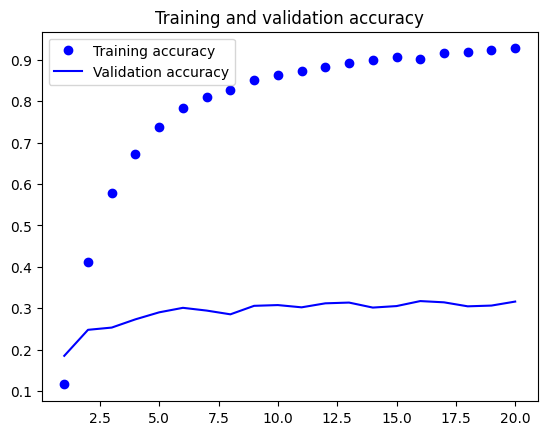

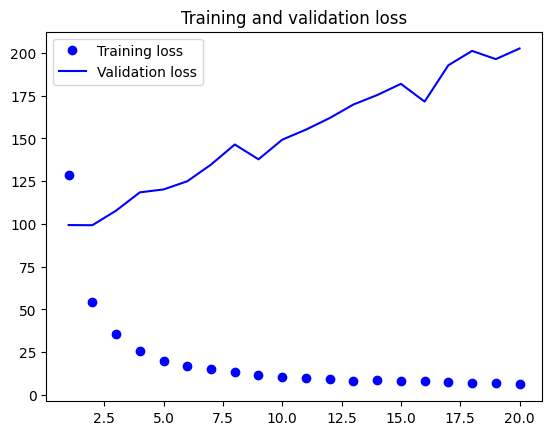

In [77]:
plot_model_performance(models_data['VGG16'][1])

### VGG19

In [78]:
base_vgg19  = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))

80134624/80134624 [==============================] - 5s 0us/step


In [79]:
models_data |= build_model(base_vgg19, keras.applications.vgg19.preprocess_input, "VGG19")

Epoch 1/20
362/362 [==============================] - 89s 241ms/step - loss: 120.6565 - accuracy: 0.1214 - val_loss: 94.9981 - val_accuracy: 0.1774
Epoch 2/20
362/362 [==============================] - 87s 239ms/step - loss: 52.5324 - accuracy: 0.4015 - val_loss: 91.5729 - val_accuracy: 0.2323
Epoch 3/20
362/362 [==============================] - 86s 236ms/step - loss: 34.0751 - accuracy: 0.5719 - val_loss: 113.4439 - val_accuracy: 0.2414
Epoch 4/20
362/362 [==============================] - 86s 236ms/step - loss: 24.3294 - accuracy: 0.6719 - val_loss: 109.4585 - val_accuracy: 0.2722
Epoch 5/20
362/362 [==============================] - 86s 236ms/step - loss: 19.1830 - accuracy: 0.7351 - val_loss: 123.2622 - val_accuracy: 0.2692
Epoch 6/20
362/362 [==============================] - 86s 236ms/step - loss: 16.9990 - accuracy: 0.7731 - val_loss: 119.7067 - val_accuracy: 0.2861
Epoch 7/20
362/362 [==============================] - 86s 236ms/step - loss: 13.7635 - accuracy: 0.8064 - val_los

In [80]:
evaluate_model(models_data['VGG19'][0])

103/103 [==============================] - 20s 195ms/step
Test accuracy: 0.316
Test macro F1-Score: 0.2954067696894949


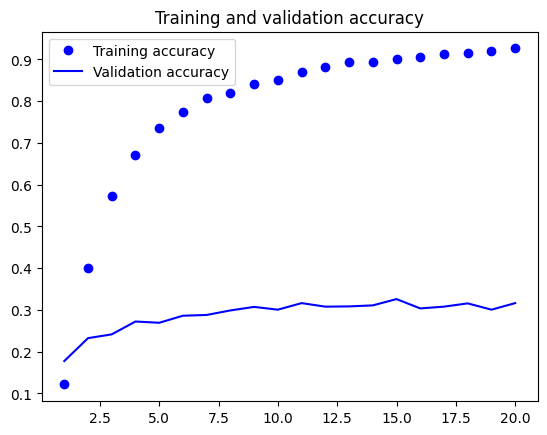

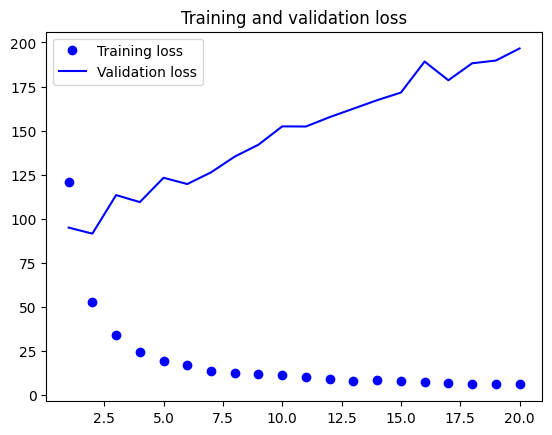

In [81]:
plot_model_performance(models_data['VGG19'][1])

## Mobilenet

In [93]:
base_mobilenet = keras.applications.MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))

In [94]:
models_data |= build_model(base_mobilenet, keras.applications.mobilenet.preprocess_input, "Mobilenet")

Epoch 1/20
362/362 [==============================] - 27s 69ms/step - loss: 82.3413 - accuracy: 0.1076 - val_loss: 59.6792 - val_accuracy: 0.1961
Epoch 2/20
362/362 [==============================] - 25s 67ms/step - loss: 33.0900 - accuracy: 0.4102 - val_loss: 57.2893 - val_accuracy: 0.2541
Epoch 3/20
362/362 [==============================] - 24s 65ms/step - loss: 18.9316 - accuracy: 0.6048 - val_loss: 65.8701 - val_accuracy: 0.2378
Epoch 4/20
362/362 [==============================] - 24s 65ms/step - loss: 13.5514 - accuracy: 0.7091 - val_loss: 64.5677 - val_accuracy: 0.2873
Epoch 5/20
362/362 [==============================] - 24s 65ms/step - loss: 10.3539 - accuracy: 0.7692 - val_loss: 69.5676 - val_accuracy: 0.2981
Epoch 6/20
362/362 [==============================] - 24s 65ms/step - loss: 9.2239 - accuracy: 0.8008 - val_loss: 65.9188 - val_accuracy: 0.3005
Epoch 7/20
362/362 [==============================] - 24s 65ms/step - loss: 7.5061 - accuracy: 0.8366 - val_loss: 75.2113 - v

In [95]:
evaluate_model(models_data['Mobilenet'][0])

103/103 [==============================] - 5s 43ms/step
Test accuracy: 0.345
Test macro F1-Score: 0.3159235142425808


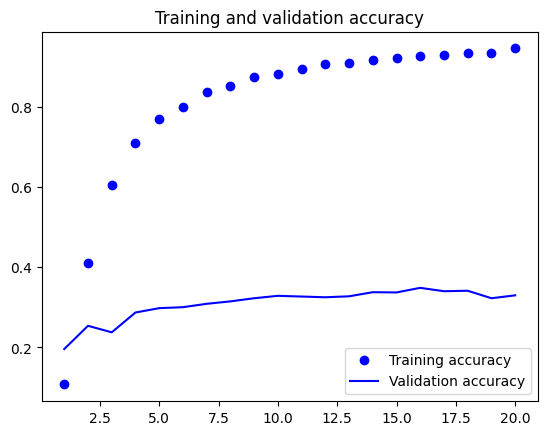

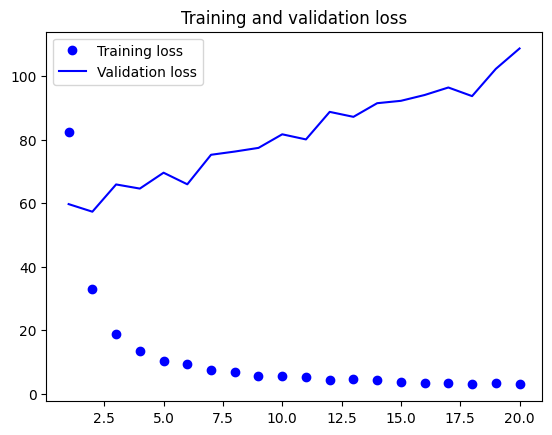

In [96]:
plot_model_performance(models_data['Mobilenet'][1])

## EfficientNet

### EfficientNetB0

In [97]:
base_efficientnetB0 = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

16705208/16705208 [==============================] - 2s 0us/step


In [98]:
models_data |= build_model(base_efficientnetB0, keras.applications.efficientnet.preprocess_input, "EfficientNetB0")

Epoch 1/20
362/362 [==============================] - 50s 117ms/step - loss: 40.9678 - accuracy: 0.1292 - val_loss: 30.4583 - val_accuracy: 0.2342
Epoch 2/20
362/362 [==============================] - 39s 106ms/step - loss: 20.3069 - accuracy: 0.4001 - val_loss: 29.7067 - val_accuracy: 0.2867
Epoch 3/20
362/362 [==============================] - 37s 101ms/step - loss: 13.7439 - accuracy: 0.5469 - val_loss: 30.8513 - val_accuracy: 0.3024
Epoch 4/20
362/362 [==============================] - 37s 101ms/step - loss: 10.1868 - accuracy: 0.6449 - val_loss: 33.9764 - val_accuracy: 0.3084
Epoch 5/20
362/362 [==============================] - 37s 101ms/step - loss: 8.1500 - accuracy: 0.7000 - val_loss: 37.0446 - val_accuracy: 0.3090
Epoch 6/20
362/362 [==============================] - 37s 101ms/step - loss: 7.0302 - accuracy: 0.7444 - val_loss: 39.9748 - val_accuracy: 0.3271
Epoch 7/20
362/362 [==============================] - 37s 100ms/step - loss: 6.1364 - accuracy: 0.7792 - val_loss: 39.65

In [99]:
evaluate_model(models_data['EfficientNetB0'][0])

103/103 [==============================] - 9s 71ms/step
Test accuracy: 0.365
Test macro F1-Score: 0.3475567801611978


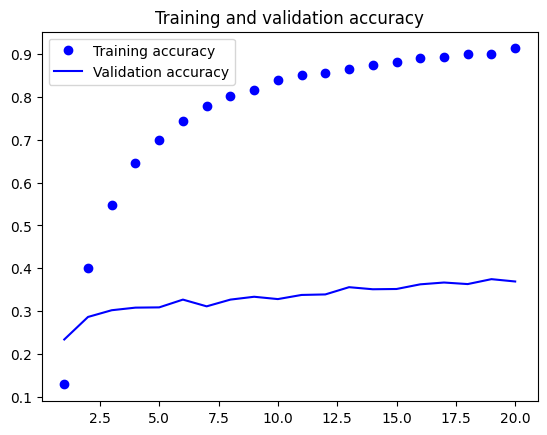

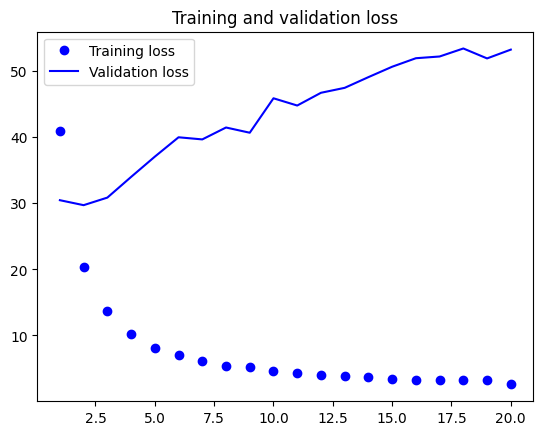

In [100]:
plot_model_performance(models_data['EfficientNetB0'][1])

### EfficientNetB5
In this case we wanted to train the deepest EfficientNet version, which is the B7 version, but both B7 and B6 raised OOM error while training in Google Colab. So we stick with the B5, which is the deepest "feasible" version of EfficientNet

In [101]:
base_efficientnetB5 = keras.applications.EfficientNetB5(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

115263384/115263384 [==============================] - 6s 0us/step


In [102]:
models_data |= build_model(base_efficientnetB5, keras.applications.efficientnet.preprocess_input, "EfficientNetB5")

Epoch 1/20
362/362 [==============================] - 136s 337ms/step - loss: 86.2534 - accuracy: 0.1020 - val_loss: 83.7495 - val_accuracy: 0.1267
Epoch 2/20
362/362 [==============================] - 114s 313ms/step - loss: 52.8982 - accuracy: 0.2623 - val_loss: 63.9528 - val_accuracy: 0.2076
Epoch 3/20
362/362 [==============================] - 110s 302ms/step - loss: 37.5719 - accuracy: 0.3794 - val_loss: 69.2241 - val_accuracy: 0.1979
Epoch 4/20
362/362 [==============================] - 114s 313ms/step - loss: 30.0212 - accuracy: 0.4642 - val_loss: 63.6414 - val_accuracy: 0.2384
Epoch 5/20
362/362 [==============================] - 110s 302ms/step - loss: 24.2334 - accuracy: 0.5304 - val_loss: 70.3690 - val_accuracy: 0.2354
Epoch 6/20
362/362 [==============================] - 110s 302ms/step - loss: 20.7566 - accuracy: 0.5784 - val_loss: 66.9358 - val_accuracy: 0.2565
Epoch 7/20
362/362 [==============================] - 110s 302ms/step - loss: 17.9829 - accuracy: 0.6297 - val_l

In [103]:
evaluate_model(models_data['EfficientNetB5'][0])

103/103 [==============================] - 28s 238ms/step
Test accuracy: 0.369
Test macro F1-Score: 0.35178204858920953


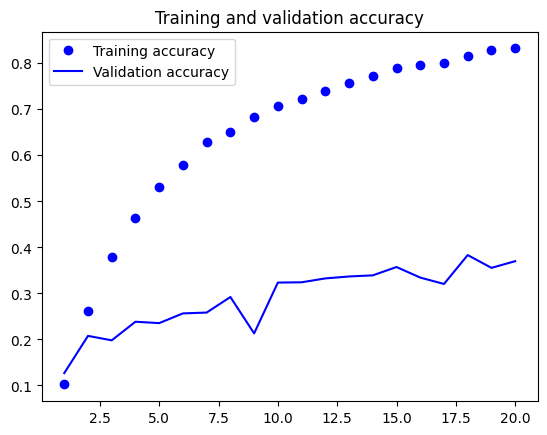

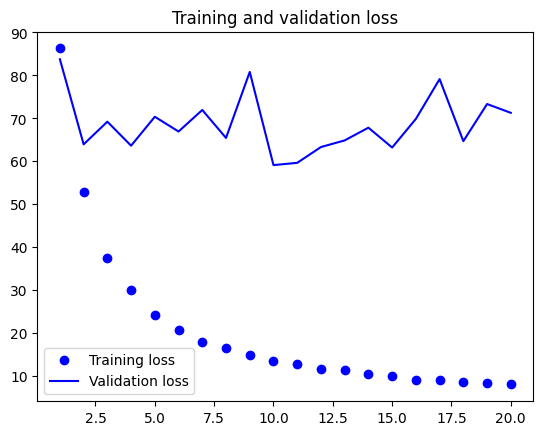

In [104]:
plot_model_performance(models_data['EfficientNetB5'][1])

## ResNet50

In [23]:
base_resnet50 = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

94765736/94765736 [==============================] - 5s 0us/step


In [24]:
models_data |= build_model(base_resnet50, keras.applications.resnet.preprocess_input, "ResNet50")

Epoch 1/20
362/362 [==============================] - 76s 186ms/step - loss: 138.3724 - accuracy: 0.1240 - val_loss: 94.6380 - val_accuracy: 0.2480
Epoch 2/20
362/362 [==============================] - 57s 155ms/step - loss: 59.8025 - accuracy: 0.4315 - val_loss: 119.5053 - val_accuracy: 0.2142
Epoch 3/20
362/362 [==============================] - 56s 152ms/step - loss: 37.3921 - accuracy: 0.6008 - val_loss: 110.8041 - val_accuracy: 0.2842
Epoch 4/20
362/362 [==============================] - 56s 154ms/step - loss: 25.8525 - accuracy: 0.7001 - val_loss: 122.9949 - val_accuracy: 0.2933
Epoch 5/20
362/362 [==============================] - 56s 153ms/step - loss: 21.0459 - accuracy: 0.7587 - val_loss: 121.7945 - val_accuracy: 0.2945
Epoch 6/20
362/362 [==============================] - 56s 153ms/step - loss: 17.6309 - accuracy: 0.7960 - val_loss: 130.0425 - val_accuracy: 0.3144
Epoch 7/20
362/362 [==============================] - 56s 153ms/step - loss: 15.8175 - accuracy: 0.8213 - val_lo

In [25]:
evaluate_model(models_data['ResNet50'][0])

103/103 [==============================] - 13s 120ms/step
Test accuracy: 0.371
Test macro F1-Score: 0.34427003372258824


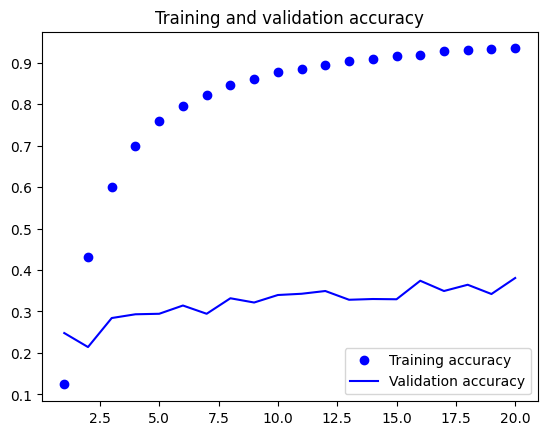

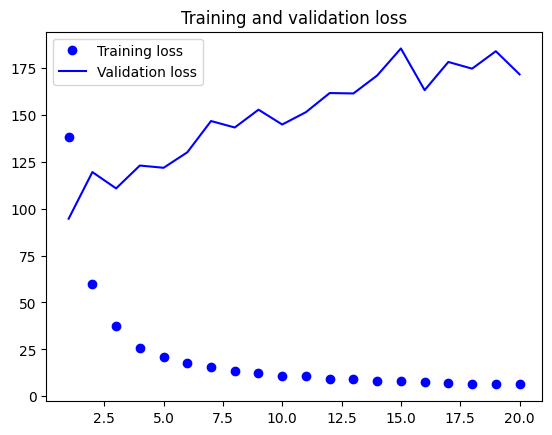

In [27]:
plot_model_performance(models_data['ResNet50'][1])

## InceptionV3

In [28]:
base_inceptionv3 = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

In [29]:
models_data |= build_model(base_inceptionv3, keras.applications.inception_v3.preprocess_input, "InceptionV3")

Epoch 1/20
362/362 [==============================] - 71s 175ms/step - loss: 83.4275 - accuracy: 0.0710 - val_loss: 76.8290 - val_accuracy: 0.0839
Epoch 2/20
362/362 [==============================] - 44s 119ms/step - loss: 47.1613 - accuracy: 0.2207 - val_loss: 79.5477 - val_accuracy: 0.0972
Epoch 3/20
362/362 [==============================] - 45s 123ms/step - loss: 31.7994 - accuracy: 0.3425 - val_loss: 50.3133 - val_accuracy: 0.2070
Epoch 4/20
362/362 [==============================] - 43s 118ms/step - loss: 22.9081 - accuracy: 0.4525 - val_loss: 57.4456 - val_accuracy: 0.1889
Epoch 5/20
362/362 [==============================] - 43s 117ms/step - loss: 18.1836 - accuracy: 0.5232 - val_loss: 54.6446 - val_accuracy: 0.2112
Epoch 6/20
362/362 [==============================] - 43s 117ms/step - loss: 15.0381 - accuracy: 0.5887 - val_loss: 53.0758 - val_accuracy: 0.2468
Epoch 7/20
362/362 [==============================] - 43s 117ms/step - loss: 12.6092 - accuracy: 0.6475 - val_loss: 59

In [30]:
evaluate_model(models_data['InceptionV3'][0])

103/103 [==============================] - 10s 89ms/step
Test accuracy: 0.259
Test macro F1-Score: 0.243064369997876


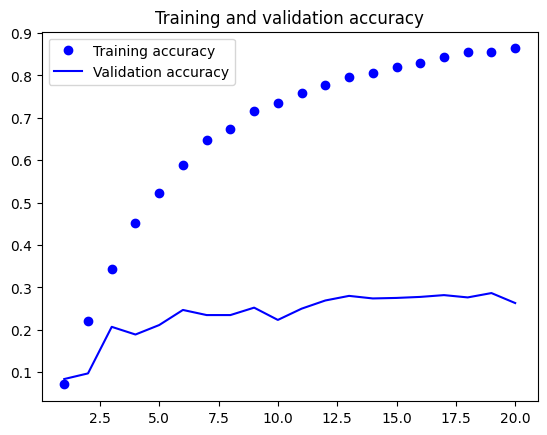

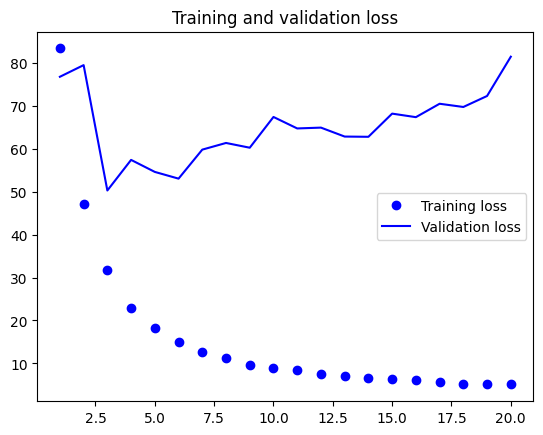

In [31]:
plot_model_performance(models_data['InceptionV3'][1])

## InceptionResNetV2

In [32]:
base_inceptionresnetv2 = keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

219055592/219055592 [==============================] - 13s 0us/step


In [33]:
models_data |= build_model(base_inceptionresnetv2, keras.applications.inception_resnet_v2.preprocess_input, "InceptionResNetV2")

Epoch 1/20
362/362 [==============================] - 132s 330ms/step - loss: 80.4309 - accuracy: 0.0718 - val_loss: 60.4671 - val_accuracy: 0.1207
Epoch 2/20
362/362 [==============================] - 102s 281ms/step - loss: 48.2748 - accuracy: 0.1889 - val_loss: 63.4570 - val_accuracy: 0.1219
Epoch 3/20
362/362 [==============================] - 106s 292ms/step - loss: 33.8617 - accuracy: 0.2884 - val_loss: 46.0011 - val_accuracy: 0.1998
Epoch 4/20
362/362 [==============================] - 102s 281ms/step - loss: 25.8655 - accuracy: 0.3667 - val_loss: 51.9558 - val_accuracy: 0.1895
Epoch 5/20
362/362 [==============================] - 106s 292ms/step - loss: 20.3963 - accuracy: 0.4471 - val_loss: 43.7734 - val_accuracy: 0.2142
Epoch 6/20
362/362 [==============================] - 103s 282ms/step - loss: 16.9266 - accuracy: 0.4982 - val_loss: 50.4206 - val_accuracy: 0.1937
Epoch 7/20
362/362 [==============================] - 102s 281ms/step - loss: 14.5185 - accuracy: 0.5471 - val_l

In [34]:
evaluate_model(models_data['InceptionResNetV2'][0])

103/103 [==============================] - 27s 233ms/step
Test accuracy: 0.233
Test macro F1-Score: 0.23416681942225867


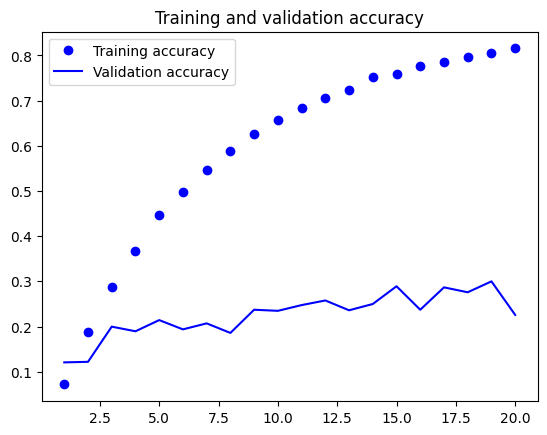

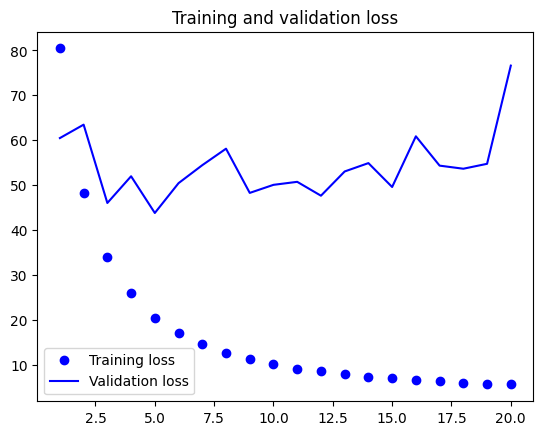

In [35]:
plot_model_performance(models_data['InceptionResNetV2'][1])

## NASNetLarge

In [36]:
base_nasnetlarge = keras.applications.NASNetLarge(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

343610240/343610240 [==============================] - 16s 0us/step


In [37]:
models_data |= build_model(base_nasnetlarge, keras.applications.nasnet.preprocess_input, "NasNetLarge")

Epoch 1/20
362/362 [==============================] - 264s 676ms/step - loss: 121.3538 - accuracy: 0.0948 - val_loss: 99.6526 - val_accuracy: 0.1599
Epoch 2/20
362/362 [==============================] - 216s 596ms/step - loss: 60.8462 - accuracy: 0.3256 - val_loss: 85.1086 - val_accuracy: 0.2052
Epoch 3/20
362/362 [==============================] - 208s 574ms/step - loss: 38.9344 - accuracy: 0.4984 - val_loss: 86.9065 - val_accuracy: 0.2323
Epoch 4/20
362/362 [==============================] - 208s 575ms/step - loss: 27.6396 - accuracy: 0.5962 - val_loss: 95.9002 - val_accuracy: 0.2342
Epoch 5/20
362/362 [==============================] - 208s 574ms/step - loss: 21.3481 - accuracy: 0.6741 - val_loss: 101.4849 - val_accuracy: 0.2366
Epoch 6/20
362/362 [==============================] - 208s 574ms/step - loss: 18.3765 - accuracy: 0.7131 - val_loss: 101.7847 - val_accuracy: 0.2661
Epoch 7/20
362/362 [==============================] - 208s 573ms/step - loss: 15.7562 - accuracy: 0.7518 - va

In [38]:
evaluate_model(models_data['NasNetLarge'][0])

103/103 [==============================] - 55s 487ms/step
Test accuracy: 0.283
Test macro F1-Score: 0.2631330704072649


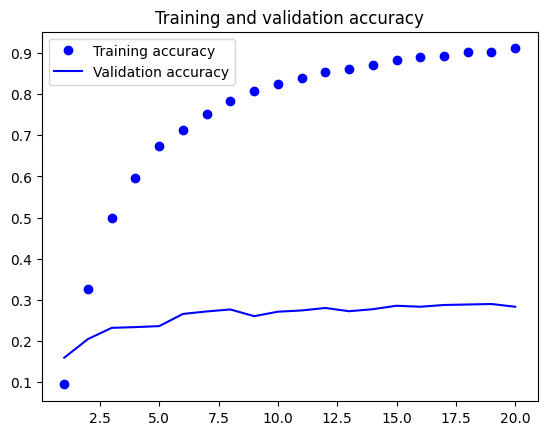

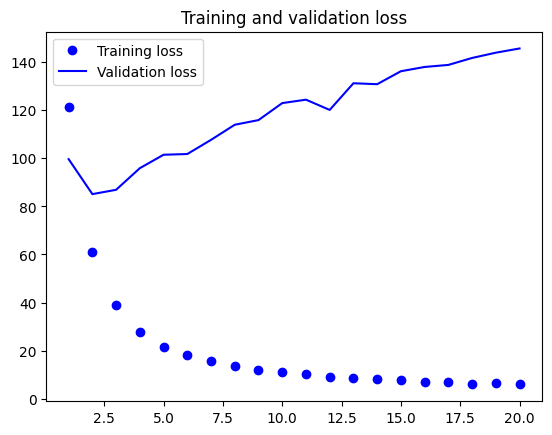

In [39]:
plot_model_performance(models_data['NasNetLarge'][1])